In [1]:
import os
import time
import warnings
import tensorflow as tf

# Suppress all TensorFlow logging (1 = errors only)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Suppress all Python warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

2025-05-15 19:59:27.960559: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 19:59:27.983080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-15 19:59:27.983099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-15 19:59:27.983992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 19:59:27.988649: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import random
import numpy as np

In [3]:
#dataset 
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [4]:
#Preprocessing dependencies
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

In [5]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load dataset
digits = load_digits()
X_all, y_all = digits.data, digits.target

# Select 1000 samples per digit class
selected_indices = []
for digit in range(10):
    class_indices = np.where(y_all == digit)[0][:1000]
    selected_indices.extend(class_indices)

# Filtered data
X = X_all[selected_indices]
y = y_all[selected_indices]

# Normalize pixel values (mean 0, std 1)
X = StandardScaler().fit_transform(X)

# Reduce to 16 PCA components
pca = PCA(n_components=12)
X = pca.fit_transform(X)

# One-hot encode labels
y_cat = to_categorical(y, num_classes=10)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42
)

In [6]:
import pennylane as qml
from pennylane.qnn import KerasLayer

# Use 12 qubits
n_qubits = 12
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define trainable weight shape: 4 layers, 12 qubits, 3 parameters per qubit
weight_shapes = {"weights": (4, n_qubits, 3)}

# Wrap as Keras-compatible layer
qlayer = KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)


2025-05-15 19:59:29.420029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-15 19:59:29.420186: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-15 19:59:29.448026: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required l

In [7]:

model = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(12,), name='PCA_Input'), 
                                    qlayer,tf.keras.layers.Dense(10, activation='softmax', name='Output_Classifier')])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 12)                144       
                                                                 
 Output_Classifier (Dense)   (None, 10)                130       
                                                                 
Total params: 274 (1.07 KB)
Trainable params: 274 (1.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Original Feature Map Circuit:
Decomposed Circuit:


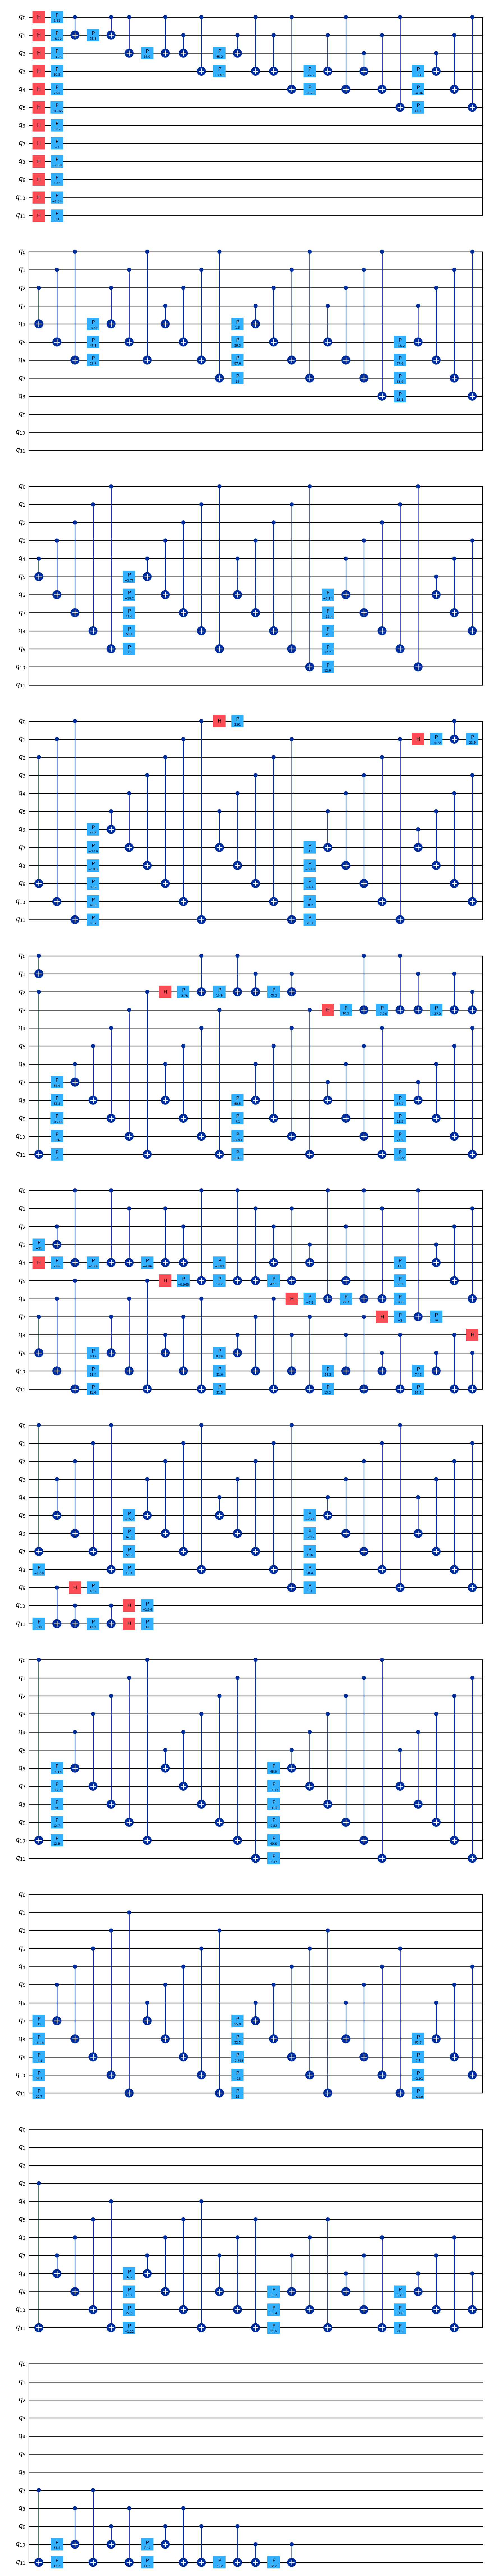

In [36]:
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap

sample_point = X_train[0] 

# Create the feature map with 16 features and 2 repetitions, but can use 1 if it runs too slowly
feature_map = ZZFeatureMap(feature_dimension=12, reps=2)

# Bindin the PCA-transformed input sample to the feature map
bound_circuit = feature_map.assign_parameters(sample_point)

# Feature map Qcircuit
print("Original Feature Map Circuit:")
bound_circuit.draw('mpl')  

# Show the decomposed circuit (i.e., expanded gates)
print("Decomposed Circuit:")
circuit_drawer(bound_circuit.decompose(), output='mpl')

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

optimizer = Adam(learning_rate=0.0005)

# Start timer
start_time = time.time()

history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

# End timer
end_time = time.time()

# Print training time
print(f"Training Time for QCNN (clean data): {end_time - start_time:.2f} seconds")

Epoch 1/50
162/162 [==============================] - 82s 505ms/step - loss: 2.3036 - accuracy: 0.0905 - val_loss: 2.3081 - val_accuracy: 0.0694
Epoch 2/50
162/162 [==============================] - 82s 503ms/step - loss: 2.2960 - accuracy: 0.0998 - val_loss: 2.3026 - val_accuracy: 0.1250
Epoch 3/50
162/162 [==============================] - 82s 505ms/step - loss: 2.2894 - accuracy: 0.1160 - val_loss: 2.2975 - val_accuracy: 0.1319
Epoch 4/50
162/162 [==============================] - 82s 506ms/step - loss: 2.2828 - accuracy: 0.1431 - val_loss: 2.2921 - val_accuracy: 0.1458
Epoch 5/50
162/162 [==============================] - 82s 505ms/step - loss: 2.2756 - accuracy: 0.1663 - val_loss: 2.2868 - val_accuracy: 0.1458
Epoch 6/50
162/162 [==============================] - 82s 505ms/step - loss: 2.2677 - accuracy: 0.1848 - val_loss: 2.2808 - val_accuracy: 0.1528
Epoch 7/50
162/162 [==============================] - 82s 504ms/step - loss: 2.2593 - accuracy: 0.1957 - val_loss: 2.2750 - val_ac

In [10]:
# Evaluate on test set
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {acc * 100:.2f}%")

Test accuracy: 29.72%


In [11]:
def deepfool_qcnn(model, input_sample, true_label, num_classes=10, overshoot=0.02, max_iter=50):
    # Reshape input and label properly
    x_adv = tf.reshape(input_sample, (1, -1))
    x_adv = tf.cast(x_adv, tf.float32)

    true_label = tf.reshape(true_label, (1, -1))
    true_label = tf.cast(true_label, tf.float32)

    for _ in range(max_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            logits = model(x_adv)
            loss = tf.keras.losses.categorical_crossentropy(true_label, logits)

        grad = tape.gradient(loss, x_adv)
        grad_norm = tf.norm(grad).numpy()

        if grad_norm < 1e-6:
            break

        # Apply perturbation
        perturbation = overshoot * grad / (grad_norm + 1e-8)
        x_adv = x_adv + perturbation

        # Check for misclassification
        pred_label = tf.argmax(model(x_adv), axis=1).numpy()[0]
        true_class = tf.argmax(true_label, axis=1).numpy()[0]

        if pred_label != true_class:
            break

    return x_adv.numpy().reshape(-1)


In [12]:
def batch_deepfool_qcnn(model, X, Y, max_samples=100, overshoot=0.02, max_iter=50):
    adv_X = []
    original_labels = []
    predicted_labels = []

    for i in range(min(len(X), max_samples)):
        x = X[i]
        y = Y[i]

        adv = deepfool_qcnn(model, x, y, overshoot=overshoot, max_iter=max_iter)
        adv_X.append(adv)

        # Predict original and adversarial labels
        x_reshaped = tf.reshape(x, (1, -1))
        adv_reshaped = tf.reshape(adv, (1, -1))

        pred_orig = tf.argmax(model(x_reshaped), axis=1).numpy()[0]
        pred_adv = tf.argmax(model(adv_reshaped), axis=1).numpy()[0]

        original_labels.append(pred_orig)
        predicted_labels.append(pred_adv)

        if (i + 1) % 10 == 0 or (i + 1) == max_samples:
            print(f"Processed {i + 1}/{max_samples}")

    return np.array(adv_X), np.array(original_labels), np.array(predicted_labels)

In [13]:
# Run DeepFool attack on the first 1000 test samples
num_samples = 1000

# Convert to float32 tensors
X_test_32 = tf.convert_to_tensor(X_test[:num_samples], dtype=tf.float32)
y_test_32 = tf.convert_to_tensor(y_test[:num_samples], dtype=tf.float32)

# Sanity check
assert X_test_32.dtype == tf.float32
assert y_test_32.dtype == tf.float32

# Measure time for adversarial example generation and evaluation
start_time = time.time()

# Generate adversarial examples
adv_X_test, y_pred_orig, y_pred_adv = batch_deepfool_qcnn(
    model, X_test_32, y_test_32, max_samples=num_samples
)

end_time = time.time()
print(f"Time taken for DeepFool attack on QCNN: {end_time - start_time:.2f} seconds")

# True labels from one-hot
y_true = tf.argmax(y_test_32, axis=1).numpy()

# Confirm shape match
assert y_pred_orig.shape == y_true.shape
assert y_pred_adv.shape == y_true.shape

# Compute accuracy
orig_acc = np.mean(y_pred_orig == y_true) * 100
adv_acc = np.mean(y_pred_adv == y_true) * 100

# Print results
print(f"\nOriginal Accuracy (Clean):     {orig_acc:.2f}%")
print(f"Adversarial Accuracy (DeepFool): {adv_acc:.2f}%")


Processed 10/1000
Processed 20/1000
Processed 30/1000
Processed 40/1000
Processed 50/1000
Processed 60/1000
Processed 70/1000
Processed 80/1000
Processed 90/1000
Processed 100/1000
Processed 110/1000
Processed 120/1000
Processed 130/1000
Processed 140/1000
Processed 150/1000
Processed 160/1000
Processed 170/1000
Processed 180/1000
Processed 190/1000
Processed 200/1000
Processed 210/1000
Processed 220/1000
Processed 230/1000
Processed 240/1000
Processed 250/1000
Processed 260/1000
Processed 270/1000
Processed 280/1000
Processed 290/1000
Processed 300/1000
Processed 310/1000
Processed 320/1000
Processed 330/1000
Processed 340/1000
Processed 350/1000
Processed 360/1000
Time taken for DeepFool attack on QCNN: 1260.38 seconds

Original Accuracy (Clean):     29.72%
Adversarial Accuracy (DeepFool): 1.67%


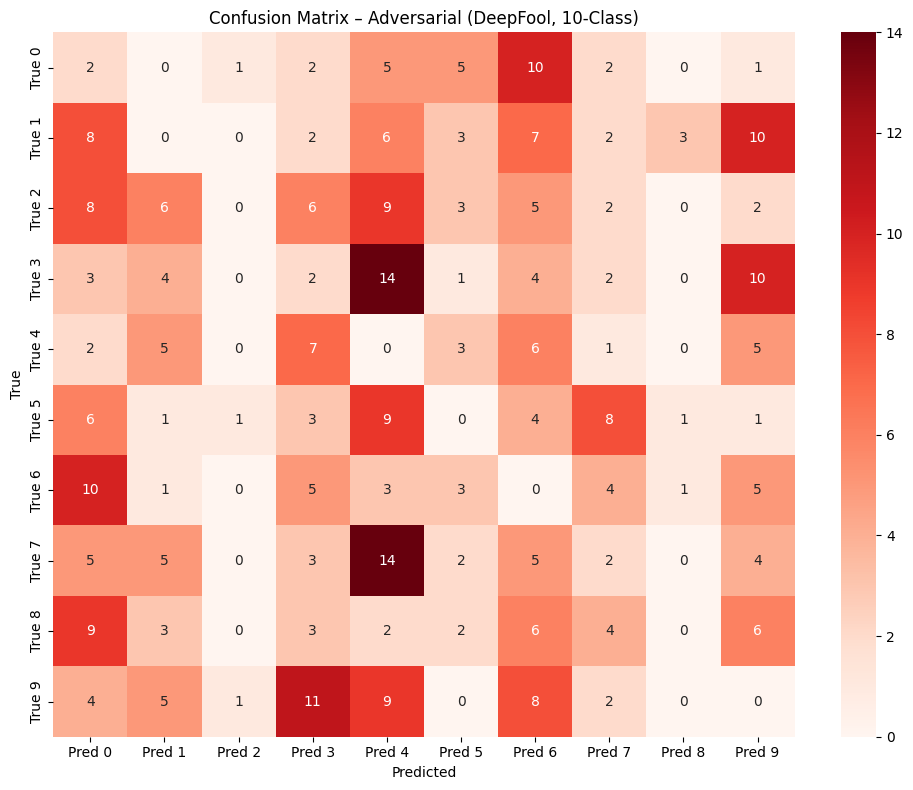

In [14]:
#Confusion matrix for adversarial predictions (10-class version)
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Compute the 10-class confusion matrix
cm_adv = confusion_matrix(y_true, y_pred_adv)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Reds',
            xticklabels=[f'Pred {i}' for i in range(10)],
            yticklabels=[f'True {i}' for i in range(10)])
plt.title("Confusion Matrix – Adversarial (DeepFool, 10-Class)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

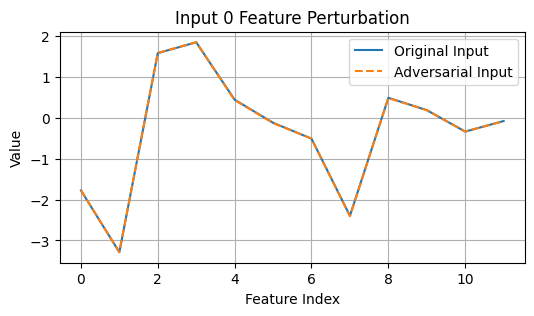

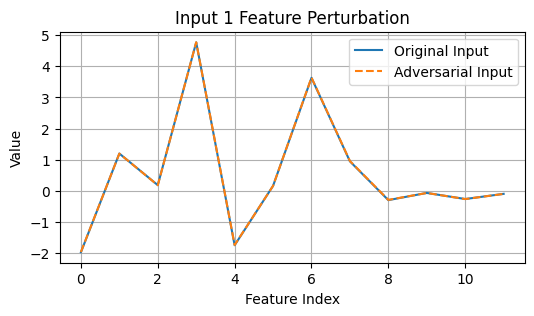

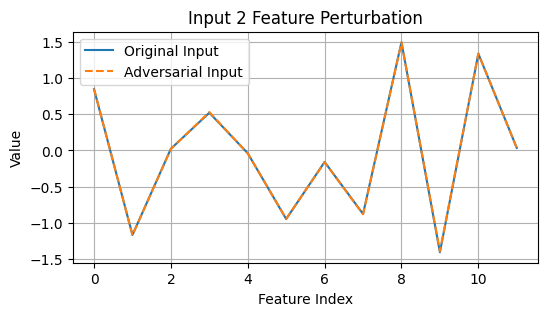

In [15]:
# Compare original and adversarial inputs (feature perturbation)
for i in range(3):  # Plot for 3 examples
    plt.figure(figsize=(6, 3))
    plt.plot(X_test[i], label='Original Input')
    plt.plot(adv_X_test[i], label='Adversarial Input', linestyle='--')
    plt.title(f"Input {i} Feature Perturbation")
    plt.xlabel("Feature Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
# Predict on clean examples
preds_clean = model.predict(X_test[:5])
print("Clean Input - Predicted probabilities:\n", preds_clean)
print("Clean Input - Predicted labels:", tf.argmax(preds_clean, axis=1).numpy())

# Predict on adversarial examples
preds_adv = model.predict(adv_X_test[:5])
print("Adversarial Input - Predicted probabilities:\n", preds_adv)
print("Adversarial Input - Predicted labels:", tf.argmax(preds_adv, axis=1).numpy())

# Show ground truth
print("True labels:", tf.argmax(y_test[:5], axis=1).numpy())

1/1 [==============================] - 0s 196ms/step
Clean Input - Predicted probabilities:
 [[0.0052706  0.08083633 0.07690553 0.18965222 0.06770102 0.09958717
  0.07785549 0.05281564 0.06555332 0.2838226 ]
 [0.17404734 0.09153637 0.1160513  0.03273237 0.114815   0.12498273
  0.09702767 0.09956934 0.10718939 0.04204848]
 [0.06128489 0.10769488 0.10125935 0.09413912 0.11342907 0.11736365
  0.11912338 0.06778694 0.11205125 0.1058675 ]
 [0.15980758 0.0854425  0.09704484 0.09613205 0.13468751 0.0993015
  0.13469176 0.03830329 0.10661339 0.0479755 ]
 [0.08284851 0.0992769  0.09696884 0.06881288 0.12598598 0.11519089
  0.08659481 0.16074112 0.09655966 0.06702039]]
Clean Input - Predicted labels: [9 0 6 0 7]
1/1 [==============================] - 0s 199ms/step
Adversarial Input - Predicted probabilities:
 [[0.00506411 0.08126705 0.07656961 0.19022767 0.06751774 0.09925125
  0.07659949 0.05280744 0.06483298 0.2858627 ]
 [0.17814738 0.08961654 0.11584342 0.03256895 0.11387572 0.12464321
  0.09

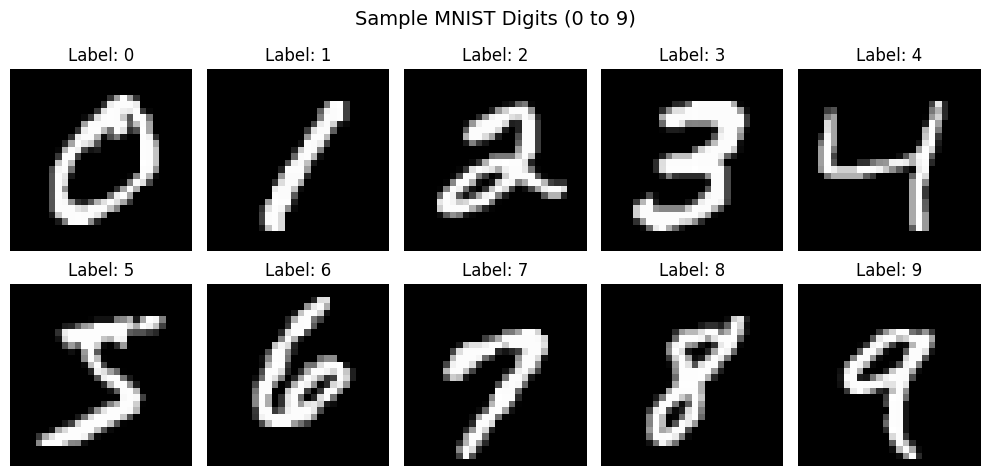

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

(X_full, y_full), _ = mnist.load_data()

# Plot one sample per digit class (0–9)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Sample MNIST Digits (0 to 9)", fontsize=14)

for digit in range(10):
    ax = axes[digit // 5, digit % 5]
    index = np.where(y_full == digit)[0][0]  # get the first occurrence of the digit
    ax.imshow(X_full[index], cmap='gray')
    ax.set_title(f"Label: {digit}")
    ax.axis('off')

plt.tight_layout()
plt.show()

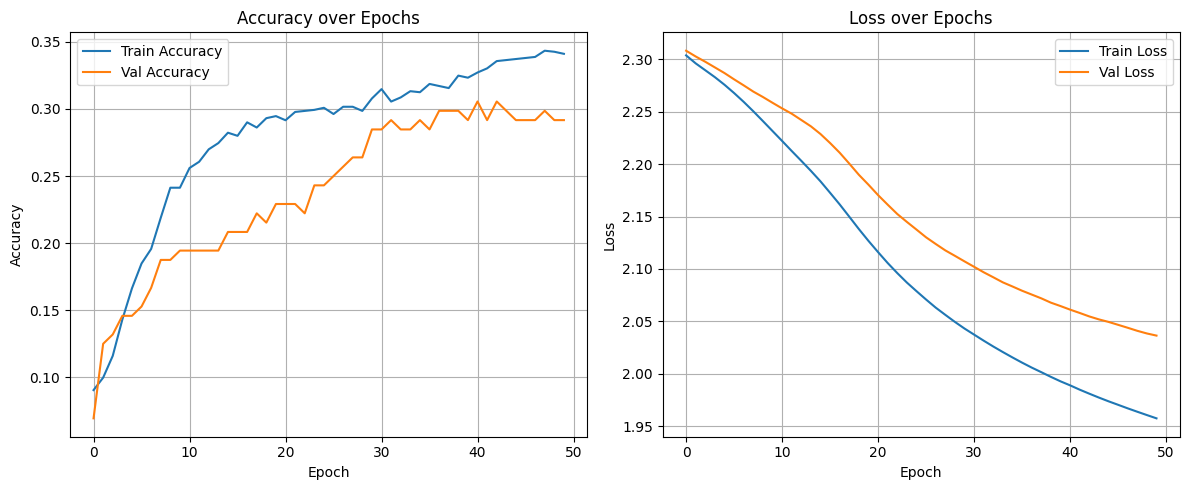

In [19]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


12/12 [==============================] - 4s 324ms/step


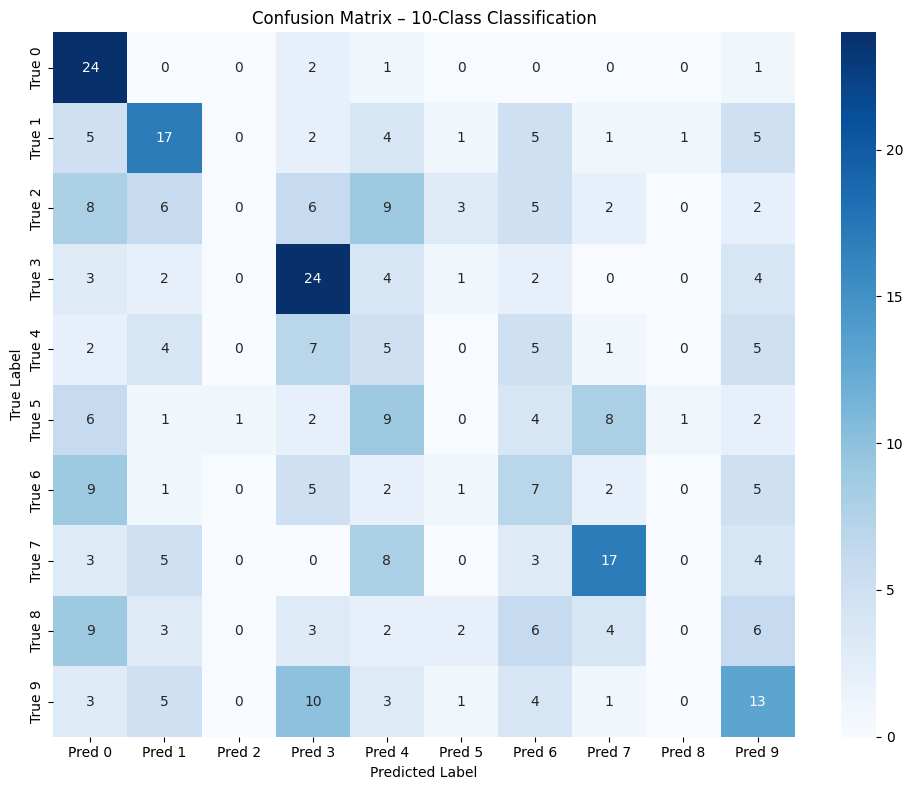

In [20]:
# Predict and convert to label indices
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Pred {i}' for i in range(10)],
            yticklabels=[f'True {i}' for i in range(10)])
plt.title("Confusion Matrix – 10-Class Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [21]:
# Choose dummy inputs and weights for visualization
import numpy as np

example_input = np.random.rand(n_qubits)
example_weights = np.random.rand(3, n_qubits, 3)  # same shape as defined earlier

# Decompose the circuit into gates and draw
drawer = qml.draw(quantum_circuit, expansion_strategy="device")(example_input, example_weights)
print(drawer)


 0: ──RX(0.18)──Rot(0.00,0.99,0.62)─╭●───────────────────────────────╭X──Rot(0.03,0.84,0.45)─╭●───
 1: ──RX(0.78)──Rot(0.61,0.01,0.02)─╰X─╭●────────────────────────────│───Rot(0.40,0.93,0.73)─│──╭●
 2: ──RX(0.60)──Rot(0.52,0.40,0.05)────╰X─╭●─────────────────────────│───Rot(0.33,0.57,0.52)─╰X─│─
 3: ──RX(0.45)──Rot(0.97,0.23,0.09)───────╰X─╭●──────────────────────│───Rot(0.96,0.84,0.75)────╰X
 4: ──RX(0.10)──Rot(0.62,0.38,0.98)──────────╰X─╭●───────────────────│───Rot(0.54,0.59,0.97)──────
 5: ──RX(0.46)──Rot(0.47,0.86,0.68)─────────────╰X─╭●────────────────│───Rot(0.61,0.28,0.30)──────
 6: ──RX(0.33)──Rot(0.45,0.01,0.94)────────────────╰X─╭●─────────────│───Rot(0.17,0.02,0.42)──────
 7: ──RX(0.14)──Rot(0.56,0.39,0.02)───────────────────╰X─╭●──────────│───Rot(0.39,0.29,0.01)──────
 8: ──RX(0.65)──Rot(0.23,0.24,0.68)──────────────────────╰X─╭●───────│───Rot(0.20,0.71,0.79)──────
 9: ──RX(0.06)──Rot(0.61,0.83,0.17)─────────────────────────╰X─╭●────│───Rot(0.61,0.93,0.65)──────
10: ──RX(0

In [22]:
from tensorflow.keras import layers, models
start_train = time.time()

# Classical CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train
cnn_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# End time
end_train = time.time()
print(f"\nClassical CNN Training Time: {end_train - start_train:.2f} seconds")

Epoch 1/20
90/90 [==============================] - 0s 672us/step - loss: 1.2905 - accuracy: 0.6444
Epoch 2/20
90/90 [==============================] - 0s 599us/step - loss: 0.4823 - accuracy: 0.8706
Epoch 3/20
90/90 [==============================] - 0s 588us/step - loss: 0.3168 - accuracy: 0.9151
Epoch 4/20
90/90 [==============================] - 0s 582us/step - loss: 0.2480 - accuracy: 0.9325
Epoch 5/20
90/90 [==============================] - 0s 564us/step - loss: 0.2094 - accuracy: 0.9408
Epoch 6/20
90/90 [==============================] - 0s 558us/step - loss: 0.1810 - accuracy: 0.9513
Epoch 7/20
90/90 [==============================] - 0s 560us/step - loss: 0.1620 - accuracy: 0.9541
Epoch 8/20
90/90 [==============================] - 0s 493us/step - loss: 0.1424 - accuracy: 0.9610
Epoch 9/20
90/90 [==============================] - 0s 506us/step - loss: 0.1299 - accuracy: 0.9624
Epoch 10/20
90/90 [==============================] - 0s 564us/step - loss: 0.1184 - accuracy: 0.9645

In [23]:
start_clean = time.time()

loss_clean, acc_clean = cnn_model.evaluate(X_test, y_test, verbose=0)

end_clean = time.time()
print(f"Accuracy on Clean Test Set: {acc_clean * 100:.2f}%")
print(f"Evaluation Time (Clean): {end_clean - start_clean:.2f} seconds")

Accuracy on Clean Test Set: 95.00%
Evaluation Time (Clean): 0.08 seconds


In [24]:
import time

start_adv_cnn = time.time()

adv_X_test_cnn, y_pred_orig_cnn, y_pred_adv_cnn = batch_deepfool_qcnn(
    cnn_model, X_test, y_test, max_samples=1000
)

end_adv_cnn = time.time()
print(f"Time taken for DeepFool attack on CNN: {end_adv_cnn - start_adv_cnn:.2f} seconds")

# Get true labels
y_true_cnn = tf.argmax(y_test[:1000], axis=1).numpy()

# Accuracy
acc_adv_cnn = np.mean(y_pred_adv_cnn == y_true_cnn) * 100
print(f"Accuracy on Adversarial (DeepFool) Test Set: {acc_adv_cnn:.2f}%")

Processed 10/1000
Processed 20/1000
Processed 30/1000
Processed 40/1000
Processed 50/1000
Processed 60/1000
Processed 70/1000
Processed 80/1000
Processed 90/1000
Processed 100/1000
Processed 110/1000
Processed 120/1000
Processed 130/1000
Processed 140/1000
Processed 150/1000
Processed 160/1000
Processed 170/1000
Processed 180/1000
Processed 190/1000
Processed 200/1000
Processed 210/1000
Processed 220/1000
Processed 230/1000
Processed 240/1000
Processed 250/1000
Processed 260/1000
Processed 270/1000
Processed 280/1000
Processed 290/1000
Processed 300/1000
Processed 310/1000
Processed 320/1000
Processed 330/1000
Processed 340/1000
Processed 350/1000
Processed 360/1000
Time taken for DeepFool attack on CNN: 34.45 seconds
Accuracy on Adversarial (DeepFool) Test Set: 60.56%


In [25]:
print("\n| Model           | Data Type          | Accuracy (%) |")
print("|----------------|--------------------|--------------|")
print(f"| Classical CNN  | Clean Test Set     | {acc_clean * 100:.2f}       |")
print(f"| Classical CNN  | DeepFool Test Set  | {acc_adv_cnn:.2f}       |")


| Model           | Data Type          | Accuracy (%) |
|----------------|--------------------|--------------|
| Classical CNN  | Clean Test Set     | 95.00       |
| Classical CNN  | DeepFool Test Set  | 60.56       |


In [26]:
# === Classical CNN on Clean Data ===
start_time = time.time()
cnn_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
cnn_train_time = time.time() - start_time

start_time = time.time()
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=0)
cnn_eval_time = time.time() - start_time

In [27]:
# === Classical CNN on DeepFool Data ===
start_time = time.time()
loss_adv, acc_adv = cnn_model.evaluate(adv_X_test, y_test, verbose=0)
cnn_adv_eval_time = time.time() - start_time


In [31]:
# === Quantum CNN on Clean Data ===
start_time = time.time()
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
qcnn_train_time = time.time() - start_time

start_time = time.time()
loss, acc = model.evaluate(X_test, y_test, verbose=0)
qcnn_eval_time = time.time() - start_time


In [32]:
# === Quantum CNN on DeepFool Data ===
start_time = time.time()
loss_adv, acc_adv = model.evaluate(adv_X_test, y_test, verbose=0)
qcnn_adv_eval_time = time.time() - start_time

In [33]:
# === Print Summary ===
print("\n=== PERFORMANCE SUMMARY (seconds) ===")
print(f"Classical CNN (Training):         {cnn_train_time:.2f}s")
print(f"Classical CNN (Eval - Clean):     {cnn_eval_time:.2f}s")
print(f"Classical CNN (Eval - DeepFool):  {cnn_adv_eval_time:.2f}s\n")
print(f"Quantum CNN (Training):           {qcnn_train_time:.2f}s")
print(f"Quantum CNN (Eval - Clean):       {qcnn_eval_time:.2f}s")
print(f"Quantum CNN (Eval - DeepFool):    {qcnn_adv_eval_time:.2f}s")


=== PERFORMANCE SUMMARY (seconds) ===
Classical CNN (Training):         0.91s
Classical CNN (Eval - Clean):     0.03s
Classical CNN (Eval - DeepFool):  0.03s

Quantum CNN (Training):           931.30s
Quantum CNN (Eval - Clean):       3.91s
Quantum CNN (Eval - DeepFool):    3.95s


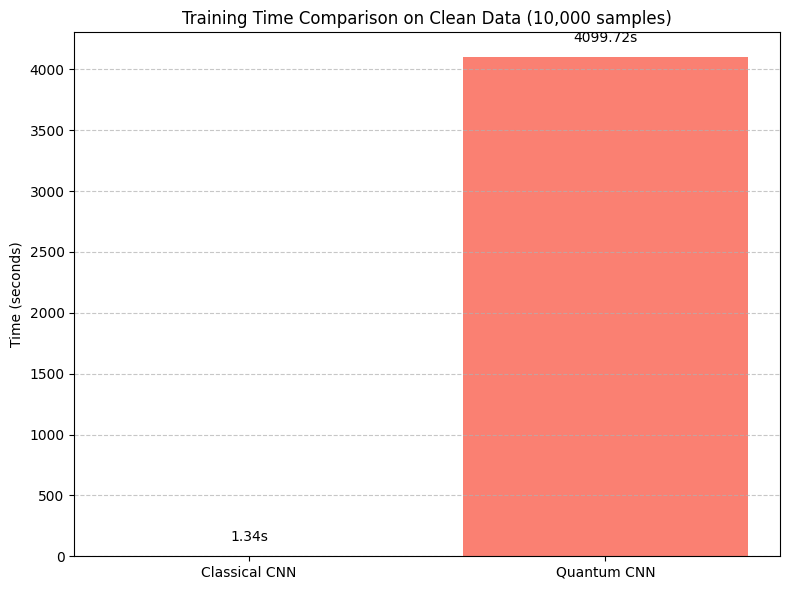

In [34]:
models = ['Classical CNN', 'Quantum CNN']
training_times = [1.34, 4099.72]  # <- updated values

plt.figure(figsize=(8, 6))
bars = plt.bar(models, training_times, color=['skyblue', 'salmon'])
plt.title("Training Time Comparison on Clean Data (10,000 samples)")
plt.ylabel("Time (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height:.2f}s',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

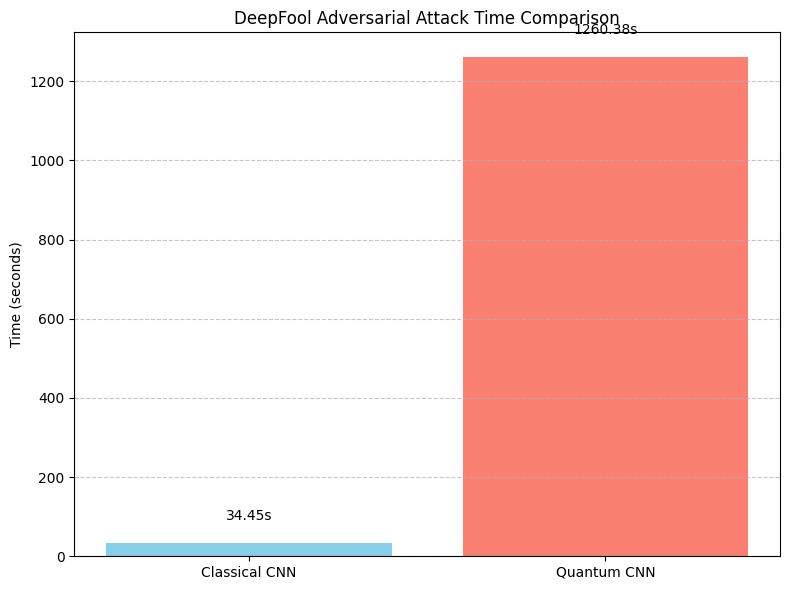

In [35]:
# DeepFool attack evaluation times (in seconds)
attack_models = ['Classical CNN', 'Quantum CNN']
attack_times = [34.45, 1260.38]

plt.figure(figsize=(8, 6))
bars = plt.bar(attack_models, attack_times, color=['skyblue', 'salmon'])
plt.title("DeepFool Adversarial Attack Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bar heights
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, f'{height:.2f}s',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()